# Binder Cumulants
From *"Thermal BCS-BEC Crossovers in finite systems"*:

*1.8 Binder cumulants*

Remind that in probability theory, a cumulant is a statistical measure that describes characteristics of a probability distribution, similar to moments. 
They are particularly useful because they simplify when random variables are added, as the cumulants of the sum of independent variables are simply the sums of the individual cumulants. 
The first few cumulants correspond to the mean, variance, skewness, and kurtosis of a distribution. The Binder cumulant (often denoted U4) is a dimensionless quantity introduced by Kurt Binder to study phase transitions and finite-size scaling in statistical physics. 
It is essentially a normalized fourth-order cumulant of an order parameter (e.g. magnetization, density of pairs, etc.) [32]. 
For an order parameter $\theta$, the Binder cumulant is defined as: 
$$
U_4 = 1 - \frac{\left<{\theta^4}\right>}{3\left<{\theta^2}\right>^2}
$$
*1.8.1 Why is it useful?*
Let us answer with a list. 
  1. Detecting phase transitions: Near a critical point, the probability distribution of the order parameter changes shape (from broad/Gaussian-like to peaked/non-Gaussian). U4 captures this change: a) In a disordered (Gaussian) regime: U4 ≈ 0; b) In an ordered regime: U4 > 0; c) At criticality: different system sizes’ U4 curves cross at the critical temperature, giving a size-independent signature.

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm, trange
from pathlib import Path
import sqlite3

from stabilvol.utility.functions import query_binned_data, roll_windows

WINDOW_LEN = 90

BEFORE_CRISIS = "2006-01-01"
CRISIS_STARTS = "2007-08-01"
CRISIS_ENDS = "2009-06-03"
AFTER_CRISIS = "2010-01-01"

MARKETS = ["UN", "UW", "LN", "JT"]
THRESHOLDS = ["1p8", "1p6"]

ROOT_DIR = Path().resolve().parent
DATABASE = ROOT_DIR / 'data/processed/trapezoidal_selection/stabilvol_filtered.sqlite'

In [175]:
def setup_optimized_connection(database_path):
    """Setup an optimized SQLite connection"""
    conn = sqlite3.connect(database_path)
    # SQLite optimizations
    conn.execute("PRAGMA journal_mode=WAL")
    conn.execute("PRAGMA synchronous=NORMAL") 
    conn.execute("PRAGMA cache_size=100000")  # Increase cache
    conn.execute("PRAGMA temp_store=MEMORY")
    return conn

# Connect to the SQLite database
conn = setup_optimized_connection(DATABASE)

In [206]:
before_windows = roll_windows(WINDOW_LEN, BEFORE_CRISIS, "2007-08-30", frequency='10D')
crisis_windows = roll_windows(WINDOW_LEN, CRISIS_STARTS, CRISIS_ENDS, frequency='3D')
after_windows = roll_windows(WINDOW_LEN, CRISIS_ENDS, "2013-01-01", frequency='10D')
print(f"Windows before crisis: {len(before_windows)}")
print(f"Windows during crisis: {len(crisis_windows)}")
print(f"Windows after crisis: {len(after_windows)}")

Windows before crisis: 52
Windows during crisis: 195
Windows after crisis: 122


In [207]:
def binder_cumulant(data, centered=True):
    x = np.asarray(data, dtype=float).ravel()
    if x.size < 2:
        return np.nan

    if centered:
        y = x - x.mean()
        m2 = np.mean(y**2)
        m4 = np.mean(y**4)
    else:
        m2 = np.mean(x**2)
        m4 = np.mean(x**4)

    if m2 <= 0:
        return np.nan
    return 1.0 - (m4 / (3.0 * m2**2))

In [189]:
binder_cumulants = []
for market in tqdm(MARKETS):
    pbar = tqdm(before_windows + crisis_windows + after_windows, 
                leave=True, desc=f"Processing market {market}")
    for i, window in enumerate(pbar):
        data = query_binned_data(
            market, window[0], window[1], t1_string=THRESHOLDS[0], t2_string=THRESHOLDS[1], conn=conn, min_bins=-1
            )[0]["FHT"].values
        
        # Compute Binder cumulants
        U4 = binder_cumulant(data)

        binder_cumulants.append((window, U4, market))

100%|██████████| 4/4 [03:34<00:00, 53.67s/it]


In [202]:
cumulants = pd.DataFrame(binder_cumulants, columns=["Window", "U4", "Market"])
cumulants["Date"] = cumulants["Window"].apply(lambda x: x[0] + (x[1] - x[0]) / 2)
cumulants["Right"] = cumulants["Window"].apply(lambda x: x[1])
cumulants

,Window,U4,Market,Date,Right
0,"(2006-01-01 00:00:00, 2006-04-01 00:00:00)",0.143463,UN,2006-02-15,2006-04-01
1,"(2006-01-11 00:00:00, 2006-04-11 00:00:00)",0.136350,UN,2006-02-25,2006-04-11
2,"(2006-01-21 00:00:00, 2006-04-21 00:00:00)",0.165417,UN,2006-03-07,2006-04-21
3,"(2006-01-31 00:00:00, 2006-05-01 00:00:00)",0.184944,UN,2006-03-17,2006-05-01
4,"(2006-02-10 00:00:00, 2006-05-11 00:00:00)",0.140031,UN,2006-03-27,2006-05-11
...,...,...,...,...,...
1459,"(2012-08-16 00:00:00, 2012-11-14 00:00:00)",-0.002067,JT,2012-09-30,2012-11-14
1460,"(2012-08-26 00:00:00, 2012-11-24 00:00:00)",-0.027049,JT,2012-10-10,2012-11-24
1461,"(2012-09-05 00:00:00, 2012-12-04 00:00:00)",-0.029883,JT,2012-10-20,2012-12-04
1462,"(2012-09-15 00:00:00, 2012-12-14 00:00:00)",-0.117865,JT,2012-10-30,2012-12-14


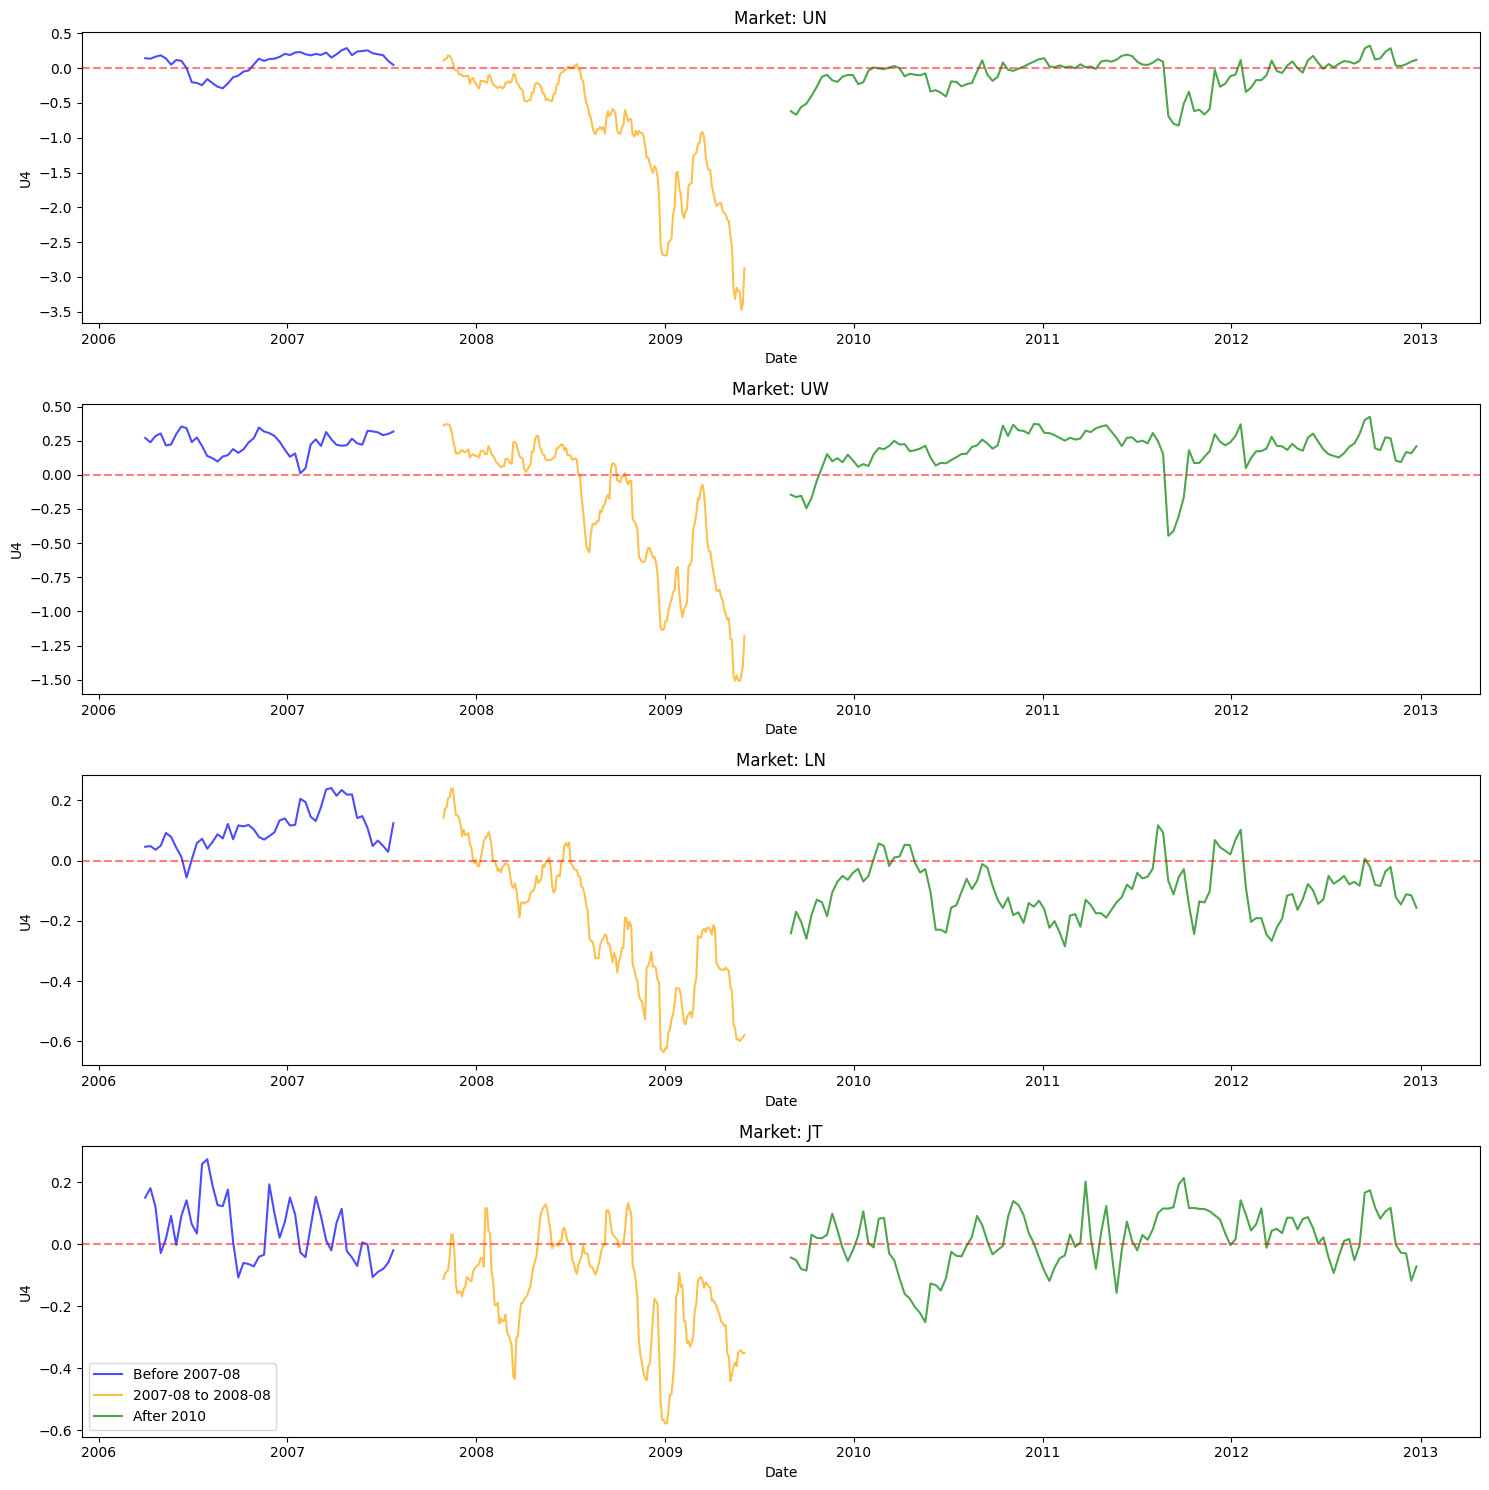

In [208]:
fig, axs = plt.subplots(len(MARKETS), figsize=(15, 15), layout='tight')
for i, market in enumerate(MARKETS):
    ax = axs[i]
    ax.set_title(f'Market: {market}')
    ax.set_xlabel('Date')
    ax.set_ylabel('U4')
    data_to_plot = cumulants[cumulants["Market"] == market]
    u4_before = data_to_plot[data_to_plot["Window"].isin(before_windows)]
    ax.plot(u4_before["Right"], u4_before["U4"], color='blue', alpha=0.7, label='Before 2007-08')
    u4_crisis = data_to_plot[data_to_plot["Window"].isin(crisis_windows)]
    ax.plot(u4_crisis["Right"], u4_crisis["U4"], color='orange', alpha=0.7, label='2007-08 to 2008-08')
    u4_after = data_to_plot[data_to_plot["Window"].isin(after_windows)]
    ax.plot(u4_after["Right"], u4_after["U4"], color='green', alpha=0.7, label='After 2010')
    ax.axhline(0, ls='--', color='red', alpha=0.5)

ax.legend()

In [205]:
print(data_to_plot[data_to_plot["Window"].isin(before_windows)].iloc[-1, 0])
print(data_to_plot[data_to_plot["Window"].isin(before_windows)].iloc[-1, -1])
print(data_to_plot[data_to_plot["Window"].isin(crisis_windows)].iloc[0, 0])


(Timestamp('2007-04-26 00:00:00'), Timestamp('2007-07-25 00:00:00'))
2007-07-25 00:00:00
(Timestamp('2007-08-01 00:00:00'), Timestamp('2007-10-30 00:00:00'))
